# 1. Time series denoising

This notebook is the Python version of the exercises of [Signal processing problems](https://www.udemy.com/course/signal-processing/). 

## 1.1 Running mean time series

A running mean time series is a filter that can be applied to smooth a given signal. For this case, a given point $y_{t}$ is equal to the average of its neighbour points. This can be expressed by:

$y_{1} = \dfrac{1}{2k+1} \sum_{i=t-k}^{t+k}x_{i}$.

This filter smoothes the sharp edges and the larger the value of k, the smoother the signal becomes. Unfortunately, this produces *edge effects* for the first and last signal points. 

It's generally appropriate when the noise is evenly (positively and negatively) distributed.

In [2]:
## IMPORTING THE VARIABLES
import numpy as np
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

In [10]:
## SETTING UP VARIABLES
sampling_rate = 1000
time = np.arange(0, 3, 1/sampling_rate) # Step size is 1/sampling_rate (time interval between samples)
n = len(time)
p = 15  # Poles for random interpolation
noiseamp = 5  # Noise level in standard deviations

## GENERATING THE SIGNAL 

# Creates an array of p random variables, between 0 and 1, scaling by 30
# Represents random amplitude values (y-axis values)
random_ampl_values = np.random.rand(p) * 30

# Generates p equally spaced values from 0 to p-1
# Represents the time/index points (x-axis values)
interp_func = interp1d(np.linspace(0, p-1, p), random_ampl_values, kind='linear')

# Generates n points to match teh samples of time vector
# Uses linear interpolation to fill in these values
ampl = interp_func(np.linspace(0, p-1, n))

# Generates n samples from a std normal distribution and scales the noise
noise = noiseamp * np.random.randn(n)

# Our signal is the sum of the amplitude and the noise
signal = ampl + noise

# Initializing the filtered signal that has the same shape and data type of signal
filtered_signal = np.zeros_like(signal)


In [22]:
## GENERATING THE FILTER

# K represents half the window size around each central point
step_size_k = 20
filter_window = 2 * step_size_k + 1

# Building the filter
for i in range(step_size_k, n - step_size_k - 1):
    # The filtered signal at each point is the mean of the signal in the window around that point
    filtered_signal[i] = np.mean(signal[i - step_size_k:i + step_size_k + 1])

# Window size in ms
# The filter window over SR (number of samples per second) is the duration in seconds 
window_size_ms = 1000 * (filter_window / sampling_rate)

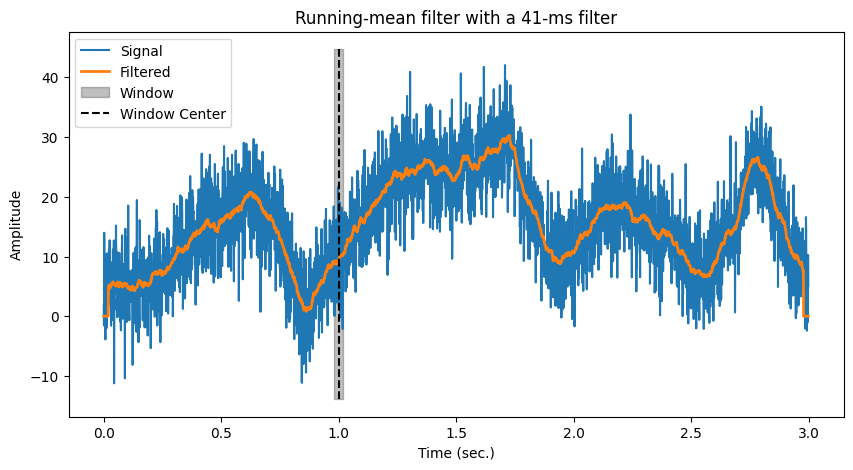

In [27]:
## GENERATING THE PLOT

# Plot the noisy and filtered signals
plt.figure(figsize=(10, 5))
plt.plot(time, signal, label='Signal')
plt.plot(time, filtered_signal, linewidth=2, label='Filtered Signal')

# Draw a patch to indicate the window size
tidx = np.argmin(np.abs(time - 1))
ylim = plt.ylim()
plt.fill_between(time[tidx-step_size_k:tidx+step_size_k+1], ylim[0], ylim[1], color='k', alpha=0.25)
plt.plot([time[tidx], time[tidx]], ylim, 'k--')

# Labeling the plot
plt.xlabel('Time (sec.)')
plt.ylabel('Amplitude')
plt.title(f'Running-mean filter with a {int(window_size_ms)}-ms filter')
plt.legend(['Signal', 'Filtered', 'Window', 'Window Center'])
plt.show()

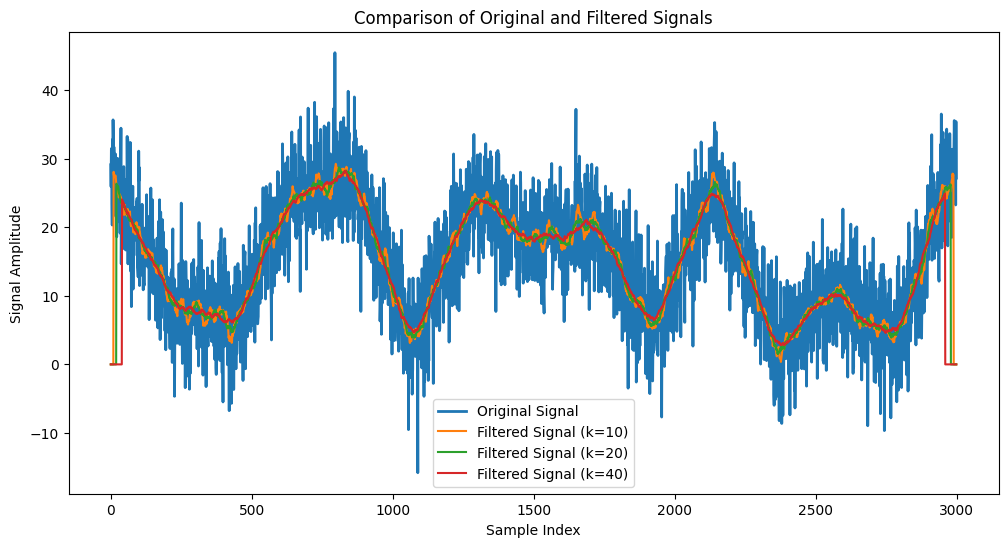

In [32]:
## EXTRA
# Let's make a comparison between different values of k for this filter

def apply_filter(signal, step_size_k):
    filtered_signal = np.zeros_like(signal)
    filter_window = 2 * step_size_k + 1
    for i in range(step_size_k, len(signal) - step_size_k):
        filtered_signal[i] = np.mean(signal[i - step_size_k:i + step_size_k + 1])
    return filtered_signal

# Values of step_size_k to compare
step_sizes = [10, 20, 40]

# Calculate filtered signals
filtered_signals = [apply_filter(signal, k) for k in step_sizes]

# Plot original and filtered signals
plt.figure(figsize=(12, 6))
plt.plot(signal, label='Original Signal', linewidth=2)

for k, filtered_signal in zip(step_sizes, filtered_signals):
    plt.plot(filtered_signal, label=f'Filtered Signal (k={k})')

plt.xlabel('Sample Index')
plt.ylabel('Signal Amplitude')
plt.title('Comparison of Original and Filtered Signals')
plt.legend()
plt.show()

## 1.2 Gaussian-smoothing time series filter

The signal is multiplied by a Gaussian-function, called $g_{i}$, which its sum is equal to one. In this sense, there's no need for an extra term to normalise our signal. Then, the probability density function is equal to 1.

The filter effect roughs out the edges, being a bit smoother than the previous filter.

The filter can be expressed as the following expression:

$y_{t} = \sum^{t+k}_{i = t - k} x_{i} g_{i}$ ,  where $g_{i} = e^{\dfrac{-4ln(2)t^2}{\omega^2}}$.

For this Gaussian-function, we can express $\omega$ as the full-width at half maximum ($fwhm$). Even though we can set this value, we empirically don't obtain it due to sampling reasons. It is important that $k$ is big enough to ensure that $g_{i}$ gets as close to zero as possible, but not making it too long, because of edge effects.

This filter is useful when the noise is normally distributed in the signal.

Empirical FWHM: 26.00 ms
FWHM set: 25.00 ms


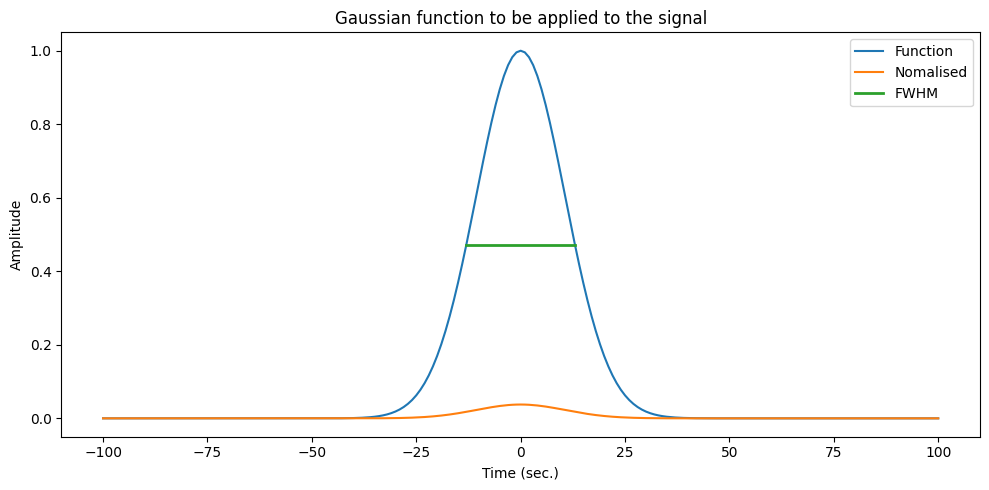

In [9]:
## GENERATING THE FILTER AND CALCULATING FWHM

# Key Gaussian-parameter, it's where the gain is 0.5
full_width_half_max = 25

# Setting up normalised time vector
k = 100
gaussian_time = 1000 * np.arange(-k, k+1) / sampling_rate

# Creating the window
gaussian_window = np.exp(-4 * np.log(2) * gaussian_time**2 / full_width_half_max**2)

# Computing the empirical fwhm, which is not exactly fwhm set before
# Slices the window from midpoint to end, finds the index where the value is closest to 0.5
pst_peak_half = k + np.argmin((gaussian_window[k:] - .5)**2)

# Findes the index where the value in the full window is closest to 0.5
pre_peak_half = np.argmin((gaussian_window - .5)**2)

# Time values corresponding to the previous found indexes
empirical_fwhm = gaussian_time[pst_peak_half] - gaussian_time[pre_peak_half]
print(f'Empirical FWHM: {empirical_fwhm:.2f} ms')
print(f'FWHM set: {full_width_half_max:.2f} ms')

# Normalising the gaussian function
normalised_gaussian_window = gaussian_window / np.sum(gaussian_window)

# Plot the noisy and filtered signals
plt.figure(figsize=(10, 5))
plt.plot(gaussian_time, gaussian_window, label='Gaussian Function')
plt.plot(gaussian_time, normalised_gaussian_window, label='Normalised Gaussian Function')
plt.plot([gaussian_time[pre_peak_half],gaussian_time[pst_peak_half]],[gaussian_window[pre_peak_half],gaussian_window[pst_peak_half]],label='FWHM',linewidth=2)
plt.xlabel('Time (sec.)')
plt.ylabel('Amplitude')
plt.title('Gaussian function to be applied to the signal')
plt.legend(['Function', 'Nomalised', 'FWHM'])
plt.tight_layout()
plt.show()

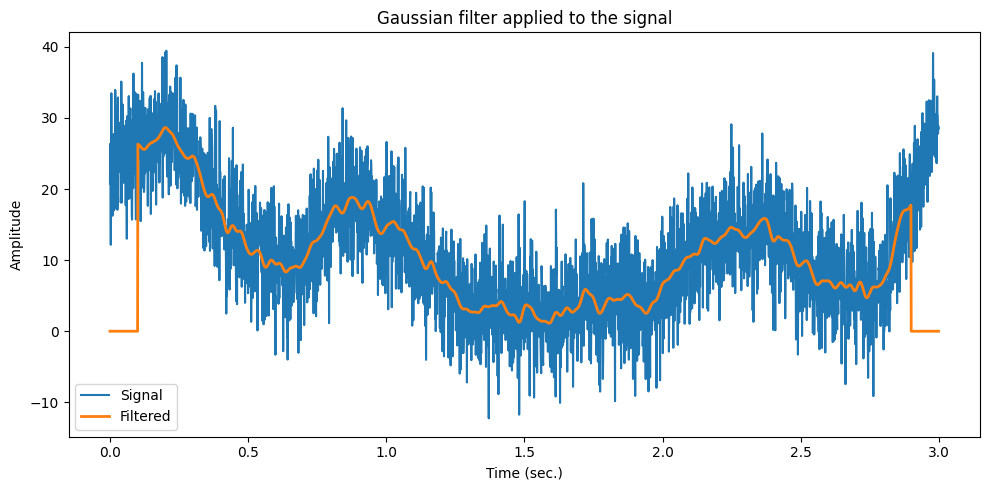

In [11]:
for i in range(k+1, n-k):
    filtered_signal[i] = np.sum(signal[i-k:i+k+1] * normalised_gaussian_window) 

# Plot the noisy and filtered signals
plt.figure(figsize=(10, 5))
plt.plot(time, signal, label='Signal')
plt.plot(time, filtered_signal, linewidth=2, label='Filtered Signal')
plt.xlabel('Time (sec.)')
plt.ylabel('Amplitude')
plt.legend(['Signal', 'Filtered'])
plt.title('Gaussian filter applied to the signal')
plt.tight_layout()
plt.show()